In [7]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [8]:
# Function for converting audio to spectrogram
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

sample_rate = 30000
path = Path('/content/drive/MyDrive/YuksekLisans/DLAPP/HW5/GearboxFaultDiagnosis/')
audios = []
labels = []
file_names = []
save_root = Path('/content/drive/MyDrive/YuksekLisans/DLAPP/HW5/Spectrograms/')

# Get audio data and labels from csv files
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            file_content = pd.read_csv(file_path)
            file_name = os.path.splitext(file)[0]
            
            for i in range(file_content.shape[1]): # Append each column (different sensors) as a sample
                audios.append(file_content.iloc[:,i].to_numpy())
                labels.append(Path(root).parts[-1])
                file_names.append(file_name + 'a' + str(i+1))
        else:
            continue       

min_val = np.inf
max_val = -np.inf
max_len = -np.inf

# Find maximum length to calculate pad width for shorter audio data
for audio in audios:
    current_min = np.min(audio)
    current_max = np.max(audio)
    current_len = len(audio)
    if current_min < min_val:
        min_val = current_min
    if current_max > max_val:
        max_val = current_max
    if current_len > max_len:
        max_len = current_len

# Pad zeros at the beginning of shorter audio data and save as spectrogram image
for idx, audio in enumerate(audios):
    pad_len = max_len - len(audio)
    audios[idx] = np.pad(audio, (pad_len,0), 'constant', constant_values=(0))
    save_path = save_root/labels[idx]
    save_path.mkdir(parents=True, exist_ok=True)
    _, spectrogram = log_specgram(audios[idx], sample_rate)
    plt.imsave(save_path/(str(idx) + '.png'), spectrogram.T)
    plt.close()

#plt.ylim(min_val, max_val)
#plt.axis('off')
#plt.plot(audios[23])
#plt.plot(audios[24])
#plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix

In [110]:
#torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         # Use GPU if available
data_path = Path('/content/drive/MyDrive/YuksekLisans/DLAPP/HW5/Spectrograms/') # Path of the data set

# 60 train, 10 validation and 10 test samples from 80 spectrogram images
train_size = 60
val_size = 10
test_size = 10

transform = transforms.Compose([
        transforms.Grayscale(),
        #transforms.RandomRotation(20),
        #transforms.RandomResizedCrop(128),
        #transforms.Resize((126,100)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

data_set = datasets.ImageFolder(data_path, transform=transform)
train_set, val_set, test_set = random_split(data_set, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)
test_loader = DataLoader(test_set, batch_size=2, shuffle=False)

In [111]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.do1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.do2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(93*73*32, 32)
        self.do3 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(32, 2)
        self.do4 = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.do1(x)
        x = F.silu(x)
        x = F.max_pool2d(x,2,2)
        
        x = self.conv2(x)
        x = self.do2(x)
        x = F.silu(x)
        x = F.max_pool2d(x,2,2)
     
        # To check the shape before fully connected layer
        #print(x.shape)
        x = x.view(-1,93*73*32)

        x = self.fc1(x)
        #x = F.relu(x)
        x = self.do3(x)

        x = self.fc2(x)     
        #x = F.relu(x)
        x = self.do4(x)

        return F.log_softmax(x, dim=1)

In [112]:
# Check
myInput = torch.Tensor(1, 1, 380, 301)
myNet = Net()
myOutput = myNet(myInput)
print(myOutput)

tensor([[nan, nan]], grad_fn=<LogSoftmaxBackward0>)


In [113]:
#torch.manual_seed(42)
model = Net()
if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epoch = 40

train_loss_list = []    # List to store the average training loss of each epoch
train_correct_list = [] # List to store the number of correctly predicted training samples per epoch
val_loss_list = []      # List to store the average validation loss of each epoch
val_correct_list = []   # List to store the number of correctly predicted validation samples per epoch
best_val_loss = np.inf  # To check if the validation loss is better than the one in previous epoch, if so then store the model state
model_state = None      # Variable to store the model state
model_path = Path('/content/drive/MyDrive/YuksekLisans/DLAPP/HW5/model.pt')  # Path to save the model

In [114]:
for i in range(epoch):
    print(f'EPOCH: {i+1}')

    # Train
    train_correct = 0   # Set to 0 at the start of each epoch, will be increased for each batch
    train_loss = 0      # Set to 0 at the start of each epoch, will be increased for each batch
    model.train()       # Train mode
    for b,(x_train,y_train) in enumerate(train_loader):
        #b += 1
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data,1)[1]         # The index location of each maximum value found (argmax)
        train_correct += (predicted == y_train).sum()   # Number of the correctly predicted training samples
        train_loss += loss * y_train.size(0)            # Total training loss, will be divided by sample size to get the average loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_correct_list.append(train_correct)
    avg_train_loss = train_loss / train_size
    train_loss_list.append(avg_train_loss)
    print(f'[Train     ] Loss: {train_loss_list[i]}\tAccuracy: {train_correct_list[i]/train_size}')           

    # Validation
    val_correct = 0 # Set to 0 at the start of each epoch, will be increased for each batch
    val_loss = 0    # Set to 0 at the start of each epoch, will be increased for each batch
    model.eval()    # Validation/Test mode
    with torch.no_grad():  
        for b,(x_val,y_val) in enumerate(val_loader):
            #b += 1
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)
            predicted = torch.max(y_pred.data,1)[1]     # The index location of each maximum value found (argmax)
            val_correct += (predicted == y_val).sum()   # Number of the correctly predicted validation samples
            val_loss += loss * y_val.size(0)            # Total validation loss, will be divided by sample size to get the average loss
            
    val_correct_list.append(val_correct)
    avg_val_loss = val_loss / val_size
    val_loss_list.append(avg_val_loss)
    print(f'[Validation] Loss: {val_loss_list[i]}\tAccuracy: {val_correct_list[i]/val_size}')

    # If the validation loss is better than the one in previous epoch, store the model state
    if val_loss_list[i] < best_val_loss:
        best_val_loss = val_loss_list[i]
        model_state = {
            'epoch': (i+1),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss_list[i],
            }
        print('The validation loss is better, model state is stored.')

    else:
        print('The validation loss is not better!')
    
    print('Learning rate:', optimizer.param_groups[0]['lr'])
    scheduler.step()    # Decay the learning rate
    print('-' * 75)     # End of the epoch

# After the training, save the model with best validation loss
print('Saving the model with best validation loss...')
torch.save(model_state, model_path)

EPOCH: 1
[Train     ] Loss: 4.231771945953369	Accuracy: 0.45000001788139343
[Validation] Loss: 4.915429592132568	Accuracy: 0.30000001192092896
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 2
[Train     ] Loss: 1.0901508331298828	Accuracy: 0.6000000238418579
[Validation] Loss: 0.5884214043617249	Accuracy: 0.699999988079071
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 3
[Train     ] Loss: 0.8098530769348145	Accuracy: 0.6333333849906921
[Validation] Loss: 0.43455520272254944	Accuracy: 0.800000011920929
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 4
[Train     ] Loss: 0.43943142890930176	Accuracy: 0.8333333730697632
[Validation] Loss: 1.0572656393051147	Accu

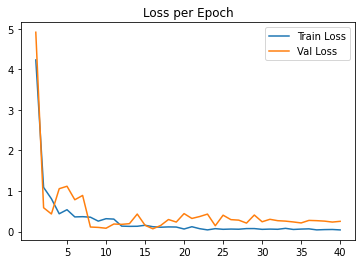

In [124]:
# Plot train and validation loss
label_epoch_no = [str(i) for i in range(1,epoch+1)]
plt.plot(label_epoch_no, train_loss_list, label='Train Loss')
plt.plot(label_epoch_no, val_loss_list, label='Val Loss')
plt.xticks([i for i in range(4,40,5)])
plt.title('Loss per Epoch')
plt.legend()

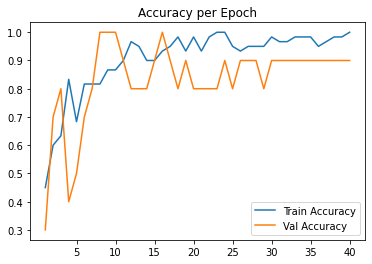

In [125]:
# Plot train and validation accuracy
plt.plot(label_epoch_no, np.divide(train_correct_list,train_size), label='Train Accuracy')
plt.plot(label_epoch_no, np.divide(val_correct_list,val_size), label='Val Accuracy')
plt.xticks([i for i in range(4,40,5)])
plt.title('Accuracy per Epoch')
plt.legend()

In [126]:
# Load the trained model with best validation loss
print('Loading the model...')
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading the model...


In [127]:
# Test
test_correct = 0    # Set to 0 at the start of each epoch, will be increased for each batch
test_loss = 0       # Set to 0 at the start of each epoch, will be increased for each batch

test_predictions = []   # List to store the test predictions
test_labels = []        # List to store the corresponding test labels

model.eval()        # Validation/Test mode
with torch.no_grad():  
    for b,(x_test,y_test) in enumerate(test_loader):
        #b += 1
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        predicted = torch.max(y_pred.data,1)[1]     # The index location of each maximum value found (argmax)
        test_correct += (predicted == y_test).sum() # Number of the correctly predicted test samples
        test_loss += loss * y_test.size(0)          # Total test loss, will be divided by sample size to get the average loss
        test_predictions.extend(predicted.cpu().view(-1))
        test_labels.extend(y_test.cpu().view(-1))

avg_test_loss = test_loss / test_size

print(f'[Test      ] Loss: {avg_test_loss}\tAccuracy: {test_correct/test_size}')

[Test      ] Loss: 0.2533908784389496	Accuracy: 0.9000000357627869


In [128]:
# Print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(2).reshape(1,2))
# Print class names
print(data_set.class_to_idx)
# Print the confusion matrix
print(confusion_matrix(test_predictions, test_labels))

[[   0    1]]
{'BrokenTooth': 0, 'Healthy': 1}
[[   3    1]
 [   0    6]]
